# CSAI 801 Project: COVID-19 Outcome Prediction
In this project we wil design different classifiers to predict the outcome (death/recovered) when a new person is admitted to the hospital. We are going to use 5 different classifier which are K-Nearest Neighbors, Logistic Regression, Naïve Bayes, Decision Trees and Support Vector Machines. And we will compare between them at the end.

We are going to use a dataset which contains 14 major variables that will be having an impact on whether someone has recovered or not. The data will be divided into three partitions: training, validation, and testing.

## Importing Libraries

First we will import the libraries and modules we need

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score,recall_score,f1_score,precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics

from sklearn.metrics import classification_report
from yellowbrick.classifier import ClassificationReport
from sklearn.preprocessing import StandardScaler

import seaborn as sns
%matplotlib inline

from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image 
import pydotplus


In [36]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from imblearn import under_sampling 
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE
from collections import Counter

In [4]:
#To plot the ROC curve for all models:

def plot_roc_curve(true_y, y_prob,auc,model_name):
    """
    plots the roc curve based of the probabilities
    """
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.subplots(1, figsize=(8,8))
    plt.plot([0, 1], ls="--")
    plt.plot(fpr, tpr,label="AUC = "+str(auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve and AUC value of {model_name} classifier')
    plt.legend(loc=4)

## Loading the data

In [5]:
data = pd.read_csv('data.csv',index_col=0)
X = data.iloc[ : , 1 :-1]
Y = data['result'] 

len_data=len(data)
print(len_data)

863


In [6]:
data.head(5)

,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


In [11]:
g0 = data[data['gender']==0]
len0=len(g0)

g1 = data[data['gender']==1]
len1=len(g1)

g2 = data[data['gender']==2]
len2=len(g2)


print(len0)
print(len1)
print(len2)

302
389
172


In [12]:
#Recovered 0

G0_r=len(g0[g0['result']==0])
G0_d=len0 - G0_r

G1_r=len(g1[g1['result']==0])
G1_d=len1 - G1_r

G2_r=len(g2[g2['result']==0])
G2_d=len2 - G2_r

print(f'From gender 0: {G0_r} recovered with percentage {round(G0_r/len0 *100)}% and {G0_d} died about {round(G0_d/len0 *100)}%')
print(f'From gender 1: {G1_r} recovered with percentage {round(G1_r/len1 *100)}% and {G1_d} died about {round(G1_d/len1 *100)}% ')
print(f'From gender 2: {G2_r} recovered with percentage {round(G2_r/len2 *100)}% and {G2_d} died about {round(G2_d/len2 *100)}% ')

From gender 0: 268 recovered with percentage 89% and 34 died about 11%
From gender 1: 320 recovered with percentage 82% and 69 died about 18% 
From gender 2: 167 recovered with percentage 97% and 5 died about 3% 


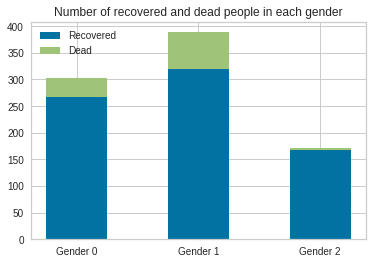

In [13]:
# Another way to check number of people got recoved and dead in each gender using a visual chart
Genders = ("Gender 0\n", "Gender 1\n", "Gender 2\n")

weight_counts = {
    "Recovered": np.array([G0_r, G1_r, G2_r]),
    "Dead": np.array([G0_d, G1_d, G2_d]),
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(Genders, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Number of recovered and dead people in each gender")
ax.legend(loc="upper left")

plt.show()

array([[<AxesSubplot:title={'center':'age'}>]], dtype=object)

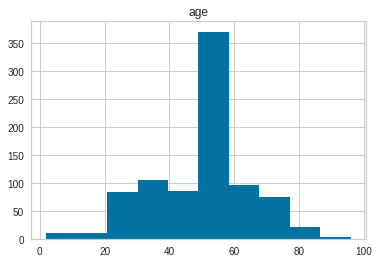

In [14]:
#Checking the range of age of the people we have in the dataset
data.hist(column='age')

<AxesSubplot:>

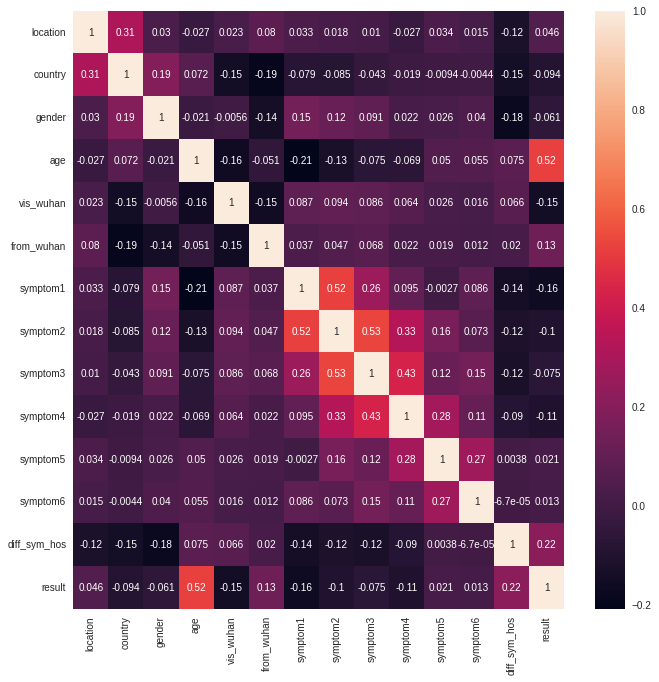

In [15]:
# calculate the correlations

import seaborn as sns

# plot the heatmap 
plt.figure (figsize=(11,11))
sns.heatmap(data=data.corr(), annot=True)


In [16]:
Y.value_counts()

0    755
1    108
Name: result, dtype: int64

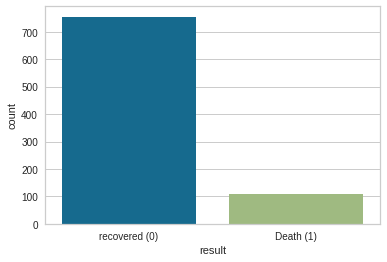

In [17]:
classes = sns.countplot(data ['result'])
classes.set_xticklabels(['recovered (0)', 'Death (1)']) 
plt.show()

Since the classes are not balanced and we have a huge difference between them, we need to use a technique to make them balanced such as SMOTE technique

In [18]:
# load library
smote = SMOTE()
# fit target and predictor variable
x_smote , y_smote = smote.fit_resample(X, Y)
print('Origianl dataset shape:', Counter(Y))
print('Balanced dataset shape:', Counter(y_smote))

Origianl dataset shape: Counter({0: 755, 1: 108})
Balanced dataset shape: Counter({1: 755, 0: 755})


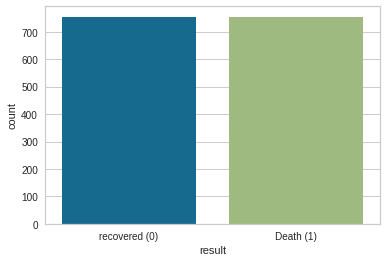

In [19]:
classes = sns.countplot(y_smote)
classes.set_xticklabels(['recovered (0)', 'Death (1)']) 
plt.show()

Now after balance the classes it's time to split the data into train and test

In [21]:
#Splite the data into Train and Test by 80% for training to 20% for testing
x_train, x_test, Y_train, Y_test = train_test_split(x_smote, y_smote, test_size = 0.20, random_state = 3, shuffle = True)

In [23]:
#Normalize the data values using StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)

Now we will use five different classifiers:

# 1. K-Nearest Neighbor

In [24]:
#Loading the model
model_knn = KNeighborsClassifier(n_neighbors=3)

## KNN Grid search

Grid search for optimal hyperpameters

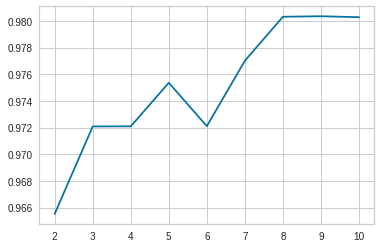

In [25]:
# Finding best cv

cv_scores = []
i_range = list(range (2,11))

for i in i_range:
    scores = cross_val_score(model_knn, x_train, Y_train, cv = i,scoring='recall')
    cv_scores.append(scores.mean())
    
plt.plot(i_range, cv_scores)

In [26]:
# Tuning KNN
parameters_knn = {'n_neighbors' : [3,5,7,9,11,13,15],'weights' : ['uniform','distance'],'metric' : ['minkowski','euclidean','manhattan']}

grid_knn = GridSearchCV(model_knn, parameters_knn, cv=10, return_train_score=False)

grid_knn.fit(x_train,Y_train)

print('KNN best paramters:',grid_knn.best_params_)
print('KNN best score:',grid_knn.best_score_)
print('KNN best estimator:',grid_knn.best_estimator_)

KNN best paramters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
KNN best score: 0.9635468319559228
KNN best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='distance')


## Check KNN performance

In [27]:
y_knn_pred = grid_knn.predict(x_test)
P_knn = precision_score(Y_test,y_knn_pred)
R_knn = recall_score(Y_test,y_knn_pred)
F1_knn = f1_score(Y_test,y_knn_pred)
Acc_knn = accuracy_score(Y_test,y_knn_pred)
print(f"The KNN model achieves precision: {round(P_knn,3)}")
print(f"The KNN model achieves recall: {round(R_knn,3)}")
print(f"The KNN model achieves f1-score {round(F1_knn,3)}")
print(f"The KNN model achieves Accuracy {round(Acc_knn,3)}")

The KNN model achieves precision: 0.933
The KNN model achieves recall: 0.952
The KNN model achieves f1-score 0.942
The KNN model achieves Accuracy 0.944


In [28]:
knn_perf = ["K-Nearest Neighbor",accuracy_score(Y_test,y_knn_pred),precision_score(Y_test , y_knn_pred),\
                       recall_score(Y_test , y_knn_pred),f1_score(Y_test , y_knn_pred),f1_score(Y_test , y_knn_pred)]

## KNN ROC Curve

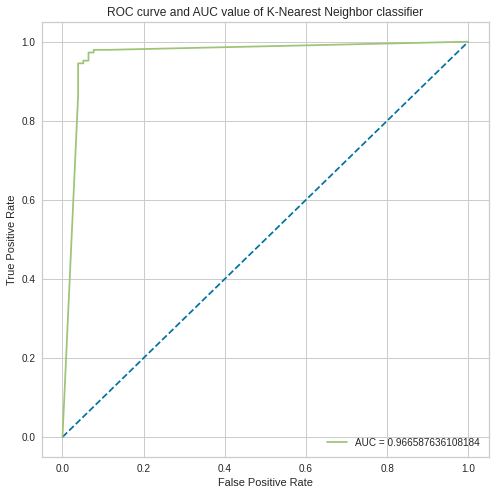

In [29]:
y_knn_prob = grid_knn.predict_proba(x_test)[:,1]
auc_knn = roc_auc_score(Y_test,y_knn_prob)
plot_roc_curve(Y_test,y_knn_prob,auc_knn,'K-Nearest Neighbor')

Text(69.0, 0.5, 'Truth')

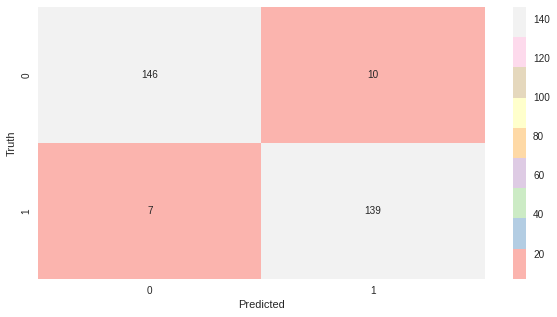

In [30]:
#Calculating Prediction
y_knn_pred = grid_knn.predict(x_test)
Con_M = confusion_matrix(Y_test, y_knn_pred)
plt.figure(figsize=(10,5))
sns.heatmap(Con_M, annot=True, fmt='g', cmap='Pastel1')
plt.legend('confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')

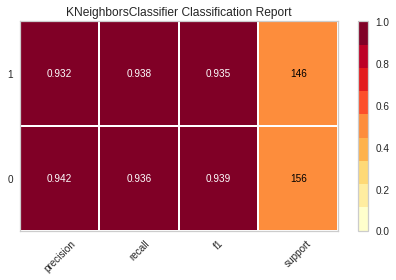

<AxesSubplot:title={'center':'KNeighborsClassifier Classification Report'}>

In [31]:
#Calculating classification Report (precision, recall, f1-score, accuracy) on test set  
classes = ['0' , '1']
visual_knn = ClassificationReport(model_knn, classes=classes, support=True)

visual_knn.fit(x_train, Y_train)        
visual_knn.score(x_test, Y_test)        
visual_knn.show() 

<AxesSubplot:>

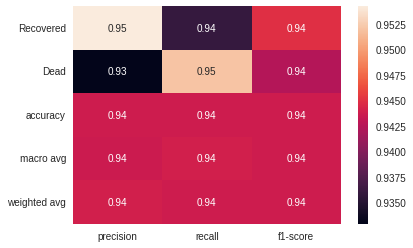

In [32]:
targets = ['Recovered','Dead']
knn_clf = classification_report(Y_test, y_knn_pred, target_names=targets, output_dict=True)
sns.heatmap(pd.DataFrame(knn_clf).iloc[:-1, :].T, annot=True)

# 2. Logistic Regression

In [38]:
#Loading the model
model_LR = LogisticRegression(random_state=0)

## Logistic Regression Grid searsh

Grid search for optimal hyperpameters

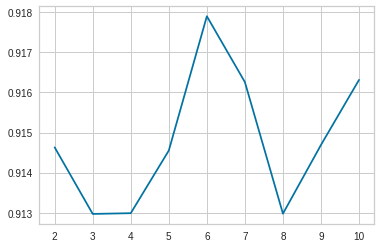

In [39]:
# Finding best cv
cv_scores = []
i_range = list(range (2,11))

for i in i_range:
    scores = cross_val_score(model_LR , x_train, Y_train, cv = i, scoring='recall')
    cv_scores.append(scores.mean())
    
plt.plot(i_range, cv_scores)

In [40]:
# Tuning LR
parameters_LR = {'penalty' : ['l2'],'C' : [1000, 100, 10, 1.0, 0.1, 0.01],'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],'max_iter' : [100, 1000,2500, 5000]}

grid_LR = GridSearchCV(model_LR, parameters_LR, cv = 6, verbose=True, n_jobs=-1)

grid_LR.fit(x_train,Y_train)

print('LR best paramters:',grid_LR.best_params_)
print('LR best score:',grid_LR.best_score_)
print('LR best estimator:',grid_LR.best_estimator_)

Fitting 6 folds for each of 120 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.6s


LR best paramters: {'C': 1000, 'max_iter': 100, 'penalty': 'l2', 'solver': 'sag'}
LR best score: 0.8957194226885375
LR best estimator: LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    4.3s finished


## Check LR performance

In [41]:
y_LR_pred = grid_LR.predict(x_test)
P_LR = precision_score(Y_test,y_LR_pred)
R_LR = recall_score(Y_test,y_LR_pred)
F1_LR = f1_score(Y_test,y_LR_pred)
Acc_LR = accuracy_score(Y_test,y_LR_pred)
print(f"The LR model achieves precision: {round(P_LR,3)}")
print(f"The LR model achieves recall: {round(R_LR,3)}")
print(f"The LR model achieves f1-score {round(F1_LR,3)}")
print(f"The LR model achieves Accuracy {round(Acc_LR,3)}")

The LR model achieves precision: 0.834
The LR model achieves recall: 0.829
The LR model achieves f1-score 0.832
The LR model achieves Accuracy 0.838


In [42]:
LR_perf = ["Logistic Regression",accuracy_score(Y_test,y_LR_pred),precision_score(Y_test , y_LR_pred),\
                       recall_score(Y_test , y_LR_pred),f1_score(Y_test , y_LR_pred),f1_score(Y_test , y_LR_pred)]

## LR ROC curve

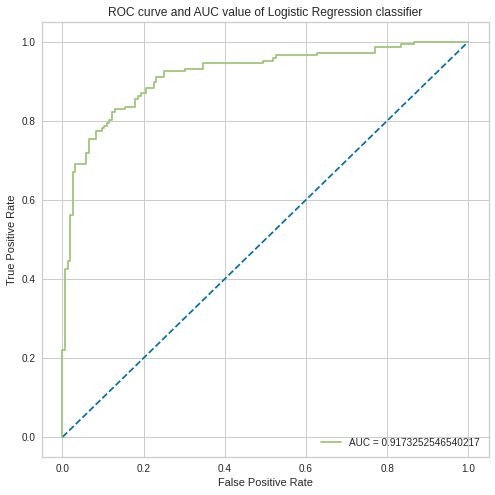

In [43]:
y_LR_prob = grid_LR.predict_proba(x_test)[:,1]
auc_LR = roc_auc_score(Y_test,y_LR_prob)
plot_roc_curve(Y_test,y_LR_prob,auc_LR,'Logistic Regression')

Text(69.0, 0.5, 'Truth')

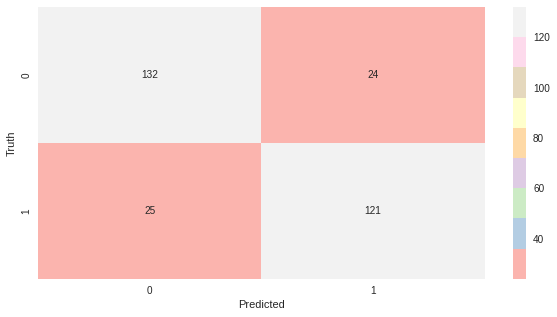

In [44]:
#Calculating Prediction
y_LR_pred = grid_LR.predict(x_test)
Con_M = confusion_matrix(Y_test, y_LR_pred)
plt.figure(figsize=(10,5))
sns.heatmap(Con_M, annot=True, fmt='g', cmap='Pastel1')
plt.legend('confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')

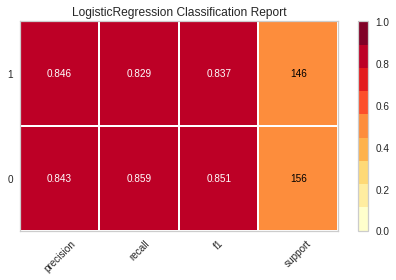

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [45]:
#Calculating classification Report (precision, recall, f1-score, accuracy) on test set  
classes = ['0' , '1']
visual_LR = ClassificationReport(model_LR, classes=classes, support=True)

visual_LR.fit(x_train, Y_train)        
visual_LR.score(x_test, Y_test)        
visual_LR.show() 

<AxesSubplot:>

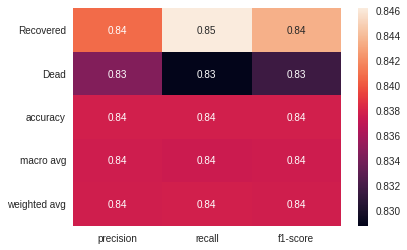

In [46]:
targets = ['Recovered','Dead']
LR_clf = classification_report(Y_test, y_LR_pred, target_names=targets, output_dict=True)
sns.heatmap(pd.DataFrame(LR_clf).iloc[:-1, :].T, annot=True)

# 3. Naïve Bayes

In [47]:
#Loading the model
model_GNB= GaussianNB()

## Naïve Bayes Grid searh

Grid search for optimal hyperpameters

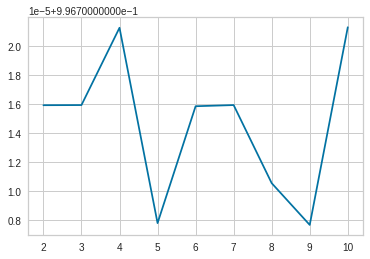

In [48]:
# Finding best cv
cv_scores = []
i_range = list(range (2,11))

for i in i_range:
    scores = cross_val_score(model_GNB , x_train, Y_train, cv = i, scoring='recall')
    cv_scores.append(scores.mean())
    
plt.plot(i_range, cv_scores)

In [49]:
# Tuning GNB
parameters_GNB = {'var_smoothing': np.logspace(0,-9, num=100)}

grid_GNB = GridSearchCV(model_GNB, parameters_GNB, cv=4, verbose=1, scoring='accuracy')

grid_GNB.fit(x_train,Y_train)

print('GNB best paramters:',grid_GNB.best_params_)
print('GNB best score:',grid_GNB.best_score_)
print('GNB best estimator:',grid_GNB.best_estimator_)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GNB best paramters: {'var_smoothing': 1.0}
GNB best score: 0.7814569536423841
GNB best estimator: GaussianNB(priors=None, var_smoothing=1.0)


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.7s finished


## Check Naïve Bayes performance

In [50]:
y_GNB_pred = grid_GNB.predict(x_test)
P_GNB = precision_score(Y_test,y_GNB_pred)
R_GNB = recall_score(Y_test,y_GNB_pred)
F1_GNB = f1_score(Y_test,y_GNB_pred)
Acc_GNB = accuracy_score(Y_test,y_GNB_pred)
print(f"The GNB model achieves precision: {round(P_GNB,3)}")
print(f"The GNB model achieves recall: {round(R_GNB,3)}")
print(f"The GNB model achieves f1-score {round(F1_GNB,3)}")
print(f"The GNB model achieves Accuracy {round(Acc_GNB,3)}")

The GNB model achieves precision: 0.672
The GNB model achieves recall: 0.938
The GNB model achieves f1-score 0.783
The GNB model achieves Accuracy 0.748


In [51]:
GNB_perf = ["Naïve Bayes",accuracy_score(Y_test,y_GNB_pred),precision_score(Y_test , y_GNB_pred),\
                       recall_score(Y_test , y_GNB_pred),f1_score(Y_test , y_GNB_pred),f1_score(Y_test , y_GNB_pred)]

## GNB ROC curve

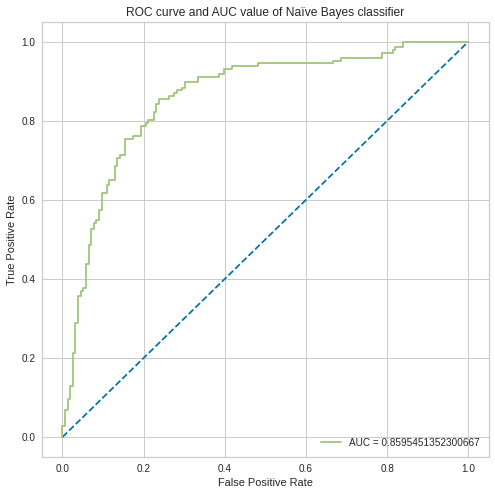

In [52]:
y_GNB_prob = grid_GNB.predict_proba(x_test)[:,1]
auc_GNB = roc_auc_score(Y_test,y_GNB_prob)
plot_roc_curve(Y_test,y_GNB_prob,auc_GNB,'Naïve Bayes')

Text(69.0, 0.5, 'Truth')

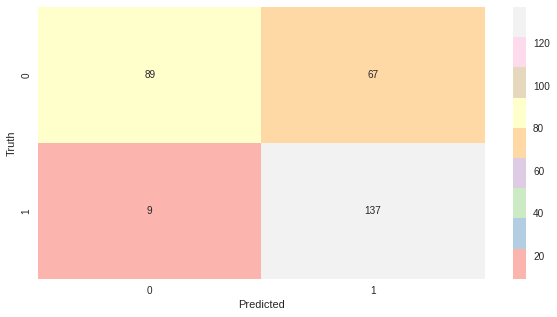

In [53]:
#Calculating Prediction
Con_M = confusion_matrix(Y_test, y_GNB_pred)
plt.figure(figsize=(10,5))
sns.heatmap(Con_M, annot=True, fmt='g', cmap='Pastel1')
plt.legend('confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')

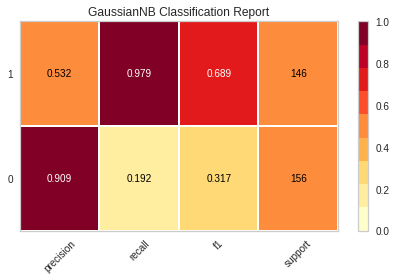

<AxesSubplot:title={'center':'GaussianNB Classification Report'}>

In [54]:
#Calculating classification Report (precision, recall, f1-score, accuracy) on test set  
classes = ['0' , '1']
visual_GNB = ClassificationReport(model_GNB, classes=classes, support=True)

visual_GNB.fit(x_train, Y_train)        
visual_GNB.score(x_test, Y_test)        
visual_GNB.show() 

<AxesSubplot:>

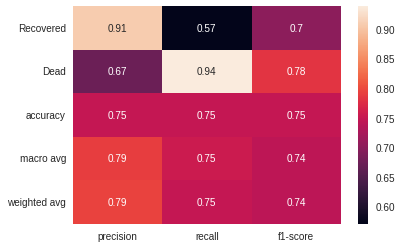

In [55]:
targets = ['Recovered','Dead']
GNB_clf = classification_report(Y_test, y_GNB_pred, target_names=targets, output_dict=True)
sns.heatmap(pd.DataFrame(GNB_clf).iloc[:-1, :].T, annot=True)

# 4. Decision Tree

In [56]:
#Loading the model
model_DT= DecisionTreeClassifier(random_state=0)

## Decision Tree Grid search

Grid search for optimal hyperpameters

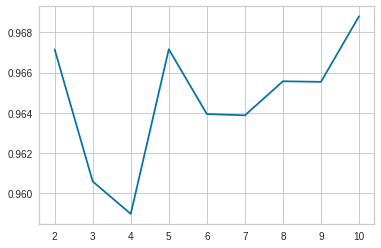

In [57]:
# Finding best cv
cv_scores = []
i_range = list(range (2,11))

for i in i_range:
    scores = cross_val_score(model_DT , x_train, Y_train, cv = i, scoring='recall')
    cv_scores.append(scores.mean())
    
plt.plot(i_range, cv_scores)

In [58]:
# Tuning DT
parameters_DT = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20],'min_samples_leaf':[1,2,3,4]}

grid_DT = GridSearchCV(model_DT, parameters_DT, n_jobs=-1, cv=5 , verbose=1,scoring='recall')

grid_DT.fit(x_train,Y_train)

print('DT best paramters:',grid_DT.best_params_)
print('DT best score:',grid_DT.best_score_)
print('DT best estimator:',grid_DT.best_estimator_)

Fitting 5 folds for each of 88 candidates, totalling 440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


DT best paramters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1}
DT best score: 0.9803143205527707
DT best estimator: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')


[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 440 out of 440 | elapsed:    0.8s finished


## Check Decision Tree performance

In [59]:
y_DT_pred = grid_DT.predict(x_test)
P_DT = precision_score(Y_test,y_DT_pred)
R_DT = recall_score(Y_test,y_DT_pred)
F1_DT = f1_score(Y_test,y_DT_pred)
Acc_DT = accuracy_score(Y_test,y_DT_pred)
print(f"The DT model achieves precision: {round(P_DT,3)}")
print(f"The DT model achieves recall: {round(R_DT,3)}")
print(f"The DT model achieves f1-score {round(F1_DT,3)}")
print(f"The DT model achieves Accuracy {round(Acc_DT,3)}")

The DT model achieves precision: 0.959
The DT model achieves recall: 0.973
The DT model achieves f1-score 0.966
The DT model achieves Accuracy 0.967


In [60]:
clf_DT = DecisionTreeClassifier(criterion= "gini", max_depth= 6 , min_samples_leaf= 1)
clf_DT.fit(x_train,Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [61]:
DT_perf = ["Decision Tree",accuracy_score(Y_test,y_DT_pred),precision_score(Y_test , y_DT_pred),\
                       recall_score(Y_test , y_DT_pred),f1_score(Y_test , y_DT_pred),f1_score(Y_test , y_DT_pred)]


## Decision Tree ROC curve

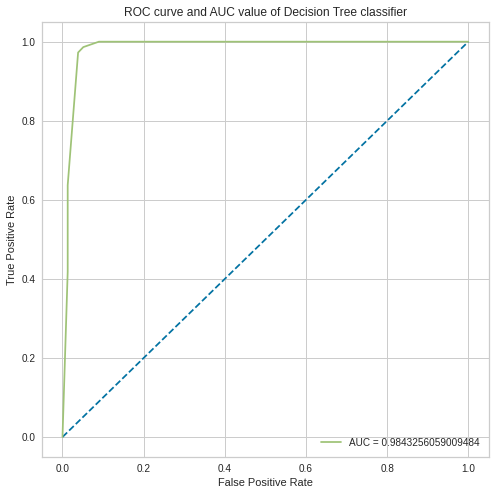

In [62]:
y_DT_prob = grid_DT.predict_proba(x_test)[:,1]
auc_DT = roc_auc_score(Y_test,y_DT_prob)
plot_roc_curve(Y_test,y_DT_prob,auc_DT,'Decision Tree')

Text(69.0, 0.5, 'Truth')

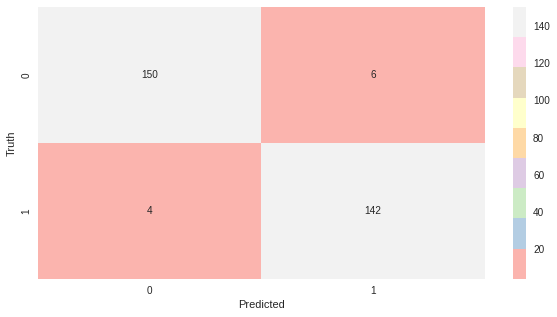

In [63]:
#Calculating Prediction
Con_M = confusion_matrix(Y_test, y_DT_pred)
plt.figure(figsize=(10,5))
sns.heatmap(Con_M, annot=True, fmt='g', cmap='Pastel1')
plt.legend('confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')

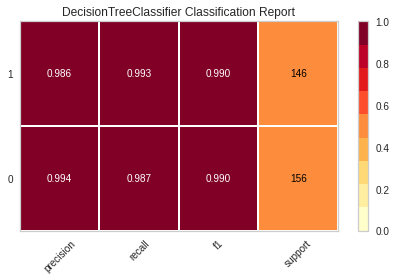

<AxesSubplot:title={'center':'DecisionTreeClassifier Classification Report'}>

In [64]:
#Calculating classification Report (precision, recall, f1-score, accuracy) on test set  
classes = ['0' , '1']
visual_DT = ClassificationReport(model_DT, classes=classes, support=True)

visual_DT.fit(x_train, Y_train)        
visual_DT.score(x_test, Y_test)        
visual_DT.show() 

<AxesSubplot:>

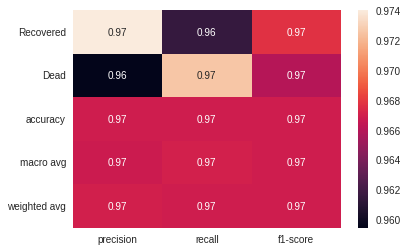

In [65]:
targets = ['Recovered','Dead']
DT_clf = classification_report(Y_test, y_DT_pred, target_names=targets, output_dict=True)
sns.heatmap(pd.DataFrame(DT_clf).iloc[:-1, :].T, annot=True)

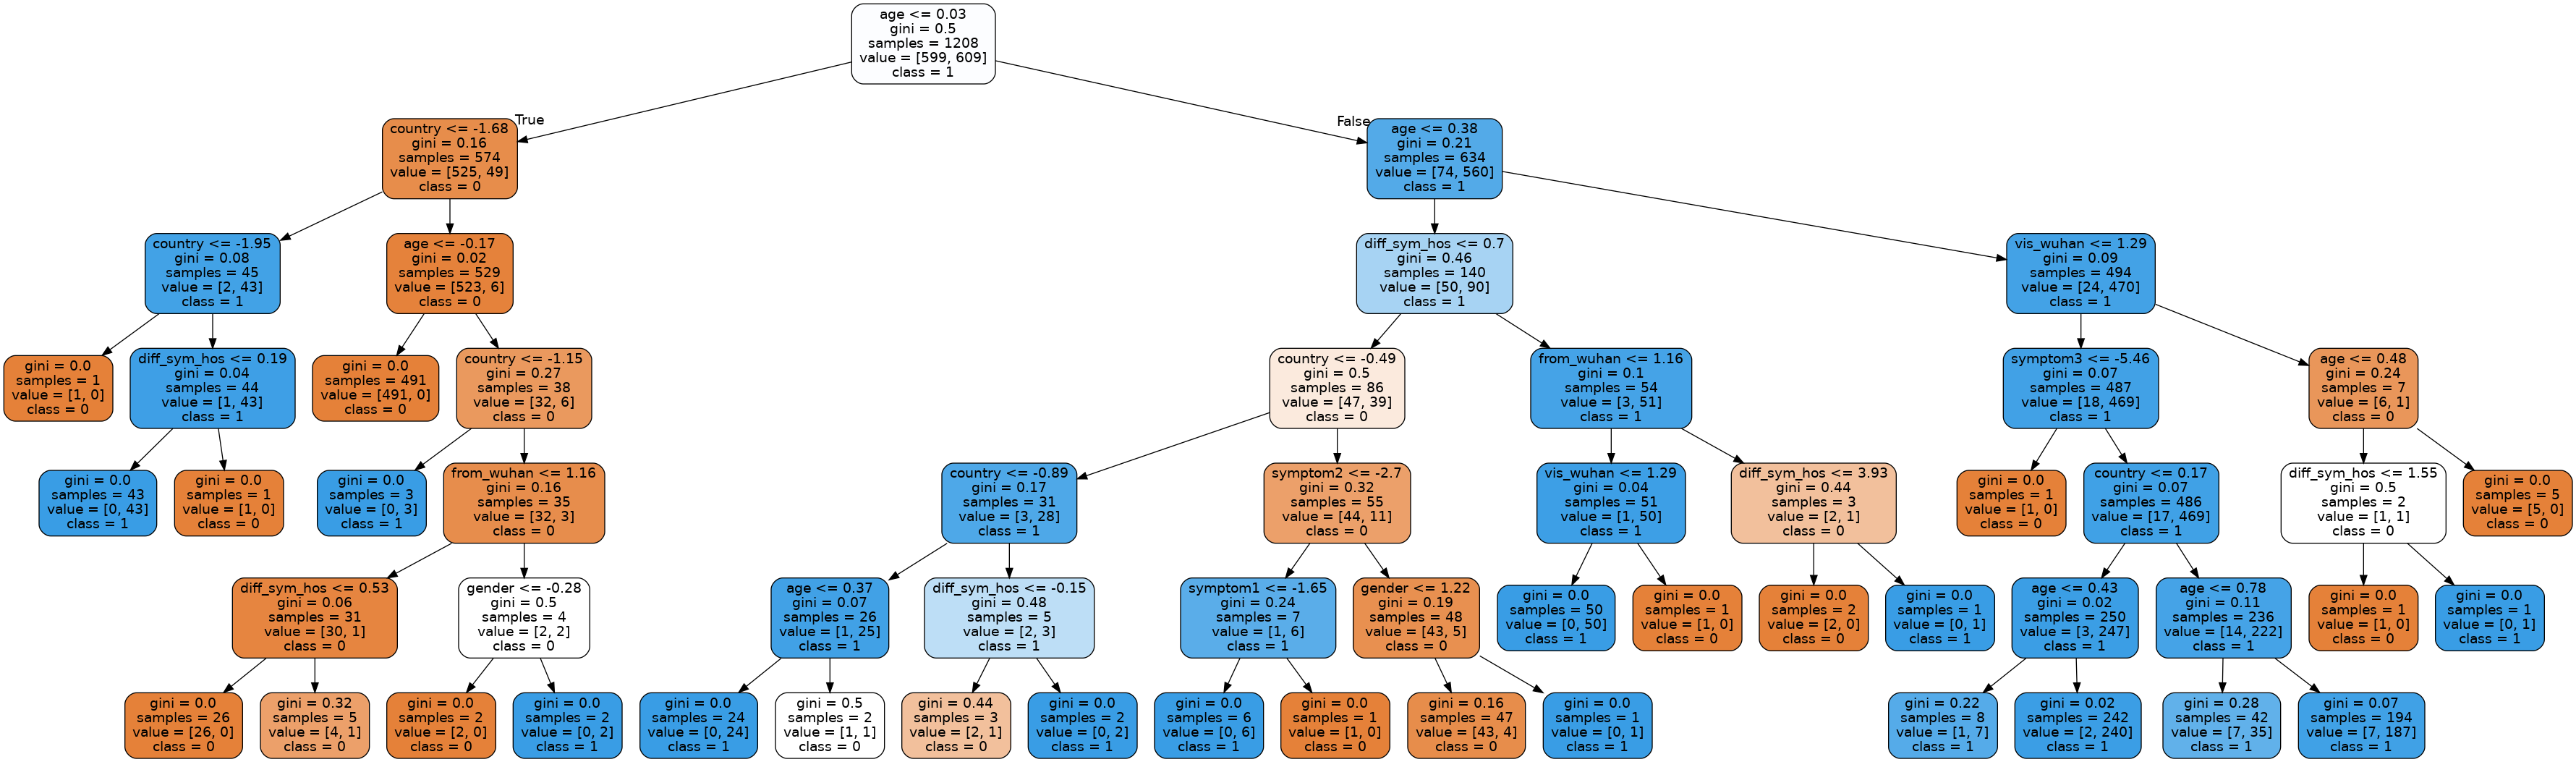

In [66]:
#Visualizing Decision Tree
import os 
import pydotplus
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz

os.environ["PATH"] += os.pathsep + 'C://Anaconda//pkgs//Graphviz//bin'

dot_data = StringIO()
feature_cols = X.columns
export_graphviz(clf_DT, out_file= dot_data, feature_names = feature_cols, class_names = ["0", "1"], rounded = True, proportion = False, precision = 2, filled = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("Decision Tree.png")
Image(graph.create_png())

# 5. Support Vector Machine

In [67]:
#Loading the model
model_SVC= SVC(probability=True)

## Support Vector Grid search

Grid search for optimal hyperpameters

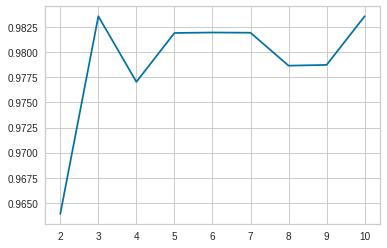

In [68]:
# Finding best cv
cv_scores = []
i_range = list(range (2,11))

for i in i_range:
    scores = cross_val_score(model_SVC , x_train, Y_train, cv = i, scoring='recall')
    cv_scores.append(scores.mean())
    
plt.plot(i_range, cv_scores)

In [69]:
# Tuning SVC
parameters_SVC = {'C': [10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf'], 'probability':[True,False]} 

grid_SVC = GridSearchCV(SVC(probability=True), param_grid=parameters_SVC, n_jobs=-1, cv=3 ,verbose=1,scoring='recall')
#grid_SVC = GridSearchCV(SVC(probability=True), param_grid=parameters_SVC, refit = True, verbose = 3, cv= 10, n_jobs= -1, scoring = 'accuracy')

grid_SVC.fit(x_train,Y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    1.2s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [10, 100, 1000],
                         'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf'],
                         'probability': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=1)

In [70]:
print('SVC best paramters:',grid_SVC.best_params_)
print('SVC best score:',grid_SVC.best_score_)
print('SVC best estimator:',grid_SVC.best_estimator_)

SVC best paramters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf', 'probability': True}
SVC best score: 0.986863711001642
SVC best estimator: SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


## Check Support Vector Performance

In [71]:
y_SVC_pred = grid_SVC.predict(x_test)
P_SVC = precision_score(Y_test,y_SVC_pred)
R_SVC = recall_score(Y_test,y_SVC_pred)
F1_SVC = f1_score(Y_test,y_SVC_pred)
Acc_SVC = accuracy_score(Y_test,y_SVC_pred)
print(f"The SVC model achieves precision: {round(P_SVC,3)}")
print(f"The SVC model achieves recall: {round(R_SVC,3)}")
print(f"The SVC model achieves f1-score {round(F1_SVC,3)}")
print(f"The SVC model achieves Accuracy {round(Acc_SVC,3)}")

The SVC model achieves precision: 0.941
The SVC model achieves recall: 0.979
The SVC model achieves f1-score 0.96
The SVC model achieves Accuracy 0.96


In [72]:
SVC_perf = ["Support Vector",accuracy_score(Y_test,y_SVC_pred),precision_score(Y_test , y_SVC_pred),\
                       recall_score(Y_test , y_SVC_pred),f1_score(Y_test , y_SVC_pred),f1_score(Y_test , y_SVC_pred)]

## Support Vector ROC curve

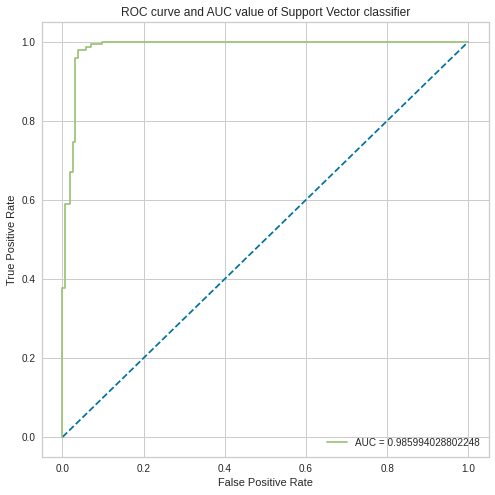

In [73]:
y_SVC_prob = grid_SVC.predict_proba(x_test)[:,1]
auc_SVC = roc_auc_score(Y_test,y_SVC_prob)
plot_roc_curve(Y_test,y_SVC_prob,auc_SVC,'Support Vector')

Text(69.0, 0.5, 'Truth')

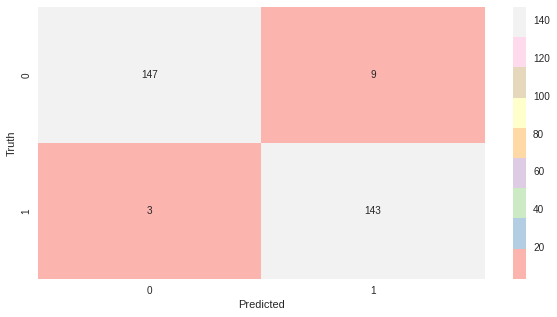

In [74]:
#Calculating Prediction
Con_M = confusion_matrix(Y_test, y_SVC_pred)
plt.figure(figsize=(10,5))
sns.heatmap(Con_M, annot=True, fmt='g', cmap='Pastel1')
plt.legend('confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')

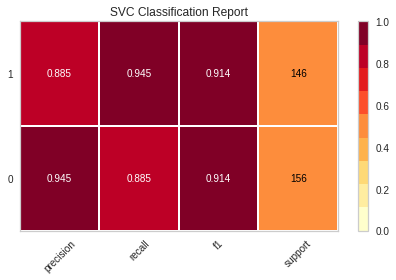

<AxesSubplot:title={'center':'SVC Classification Report'}>

In [75]:
#Calculating classification Report (precision, recall, f1-score, accuracy) on test set  
classes = ['0' , '1']
visual_SVC = ClassificationReport(model_SVC, classes=classes, support=True)

visual_SVC.fit(x_train, Y_train)        
visual_SVC.score(x_test, Y_test)        
visual_SVC.show() 

<AxesSubplot:>

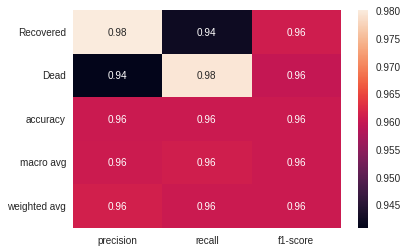

In [76]:
targets = ['Recovered','Dead']
SVC_clf = classification_report(Y_test, y_SVC_pred, target_names=targets, output_dict=True)
sns.heatmap(pd.DataFrame(SVC_clf).iloc[:-1, :].T, annot=True)

# Classifiers Comparison 

Comparison between the five classifiers according to their performance



In [77]:
column_names = ["Classifier", "Accuracy", "precision","Recall","F1 score","ROC/AUC"]

Perf = [knn_perf , LR_perf , GNB_perf , DT_perf , SVC_perf]

comparision_df = pd.DataFrame(Perf , columns = column_names)

comparision_df

,Classifier,Accuracy,precision,Recall,F1 score,ROC/AUC
0,K-Nearest Neighbor,0.943709,0.932886,0.952055,0.942373,0.942373
1,Logistic Regression,0.837748,0.834483,0.828767,0.831615,0.831615
2,Naïve Bayes,0.748344,0.671569,0.938356,0.782857,0.782857
3,Decision Tree,0.966887,0.959459,0.972603,0.965986,0.965986
4,Support Vector,0.960265,0.940789,0.979452,0.959732,0.959732
